<a href="https://colab.research.google.com/github/stmoon/CS470/blob/master/CS470_Assignment_1_CNN_classification_with_Cifar10_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CS470 Assignment #1: CNN classification with Cifar10
====


## Step 1: Connect to your Google Drive

It is required if you want to save checkpoints and load them later on.



In [1]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


## Step 2: Import modules

In [2]:
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

!pip install -U tensorboardcolab
from tensorboardcolab import TensorBoardColab

torch.manual_seed(470)
torch.cuda.manual_seed(470)

Requirement already up-to-date: tensorboardcolab in /usr/local/lib/python3.6/dist-packages (0.0.22)


Using TensorFlow backend.


## Step 3: Configure the experiments

In [3]:
# training & optimization hyper-parameters
max_epoch = 200
learning_rate = 0.001
batch_size = 20000
device = 'cuda'

# model hyper-parameters
output_dim = 10 

# Boolean value to select training process
training_process = True

# initialize tensorboard for visualization
# Note : click the Tensorboard link to see the visualization of training/testing results
tbc = TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://3d837a87.ngrok.io


## Step 4: Construct data pipeline

**`torchvision.datasets.CIFAR10`** will automatically construct **`Cifar10`** dataset.

In [4]:
data_dir = os.path.join(gdrive_root, 'my_data')

transform = transforms.Compose(
    [transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=200, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=200, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Step 5: Construct a neural network builder

We serve the baseline CNN model which is supported on Pytorch tutorial: https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/cifar10_tutorial.ipynb#scrollTo=c1E1b7-igUcR

### (You have to compare your own CNN model's test accuracy with the baseline CNN model and explain why your own model's test accuracy is higher than the basline.)

In [0]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F


class Bottleneck(nn.Module):
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4*growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4*growth_rate)
        self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat([out,x], 1)
        return out


class Transition(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = F.avg_pool2d(out, 2)
        return out


class MyDenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(MyDenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_planes = 2*growth_rate
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False)

        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans1 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3]*growth_rate

        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(num_planes, num_classes)

    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        for i in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.dense4(out)
        out = F.avg_pool2d(F.relu(self.bn(out)), 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def DenseNet121():
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=32)

def DenseNet169():
    return DenseNet(Bottleneck, [6,12,32,32], growth_rate=32)

def DenseNet201():
    return DenseNet(Bottleneck, [6,12,48,32], growth_rate=32)

def DenseNet161():
    return DenseNet(Bottleneck, [6,12,36,24], growth_rate=48)

def densenet_cifar():
    return MyDenseNet(Bottleneck, [6,12,24,16], growth_rate=12)


## Step 6: Initialize the network and optimizer

If you want to train modularized neural network in Step 5B, please use 'MyClassifier2' as 'my_classifier'. It is written as a comment now.

In [6]:
device = 'cuda'
my_classifier = densenet_cifar()
my_classifier = my_classifier.to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
 

# Print your neural network structure
# print(my_classifier)
print('parameter size : ', count_parameters(my_classifier))

optimizer = optim.Adam(my_classifier.parameters(), lr=learning_rate)


parameter size :  1000618


## Step 7: Load pre-trained weights if exist

- **For your sumbmission you have to store the trained model as a checkpoint.**
- Please do not erase this step.
- If you want to modify this step, please be careful.
- After training please confirm that your checkpoint is correctly stored and re-loaded.

In [7]:
ckpt_dir = os.path.join(gdrive_root, 'checkpoints')
if not os.path.exists(ckpt_dir):
  os.makedirs(ckpt_dir)
  
best_acc = 0.
ckpt_path = os.path.join(ckpt_dir, 'lastest.pt')
if os.path.exists(ckpt_path):
  ckpt = torch.load(ckpt_path)
  try:
    my_classifier.load_state_dict(ckpt['my_classifier'])
    optimizer.load_state_dict(ckpt['optimizer'])
    best_acc = ckpt['best_acc']
  except RuntimeError as e:
      print('wrong checkpoint')
  else:    
    print('checkpoint is loaded !')
    print('current best accuracy : %.2f' % best_acc)

checkpoint is loaded !
current best accuracy : 0.91


In [8]:
  !nvidia-smi

Sun Sep 22 23:51:25 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    58W / 149W |    360MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Step 8: Train the network

Note : It would be better to save checkpoints periodically, otherwise you'll lose everything you've trained if the session is recycled.

In [9]:
if training_process:
  it = 0
  train_losses = []
  test_losses = []
  for epoch in range(max_epoch):
    # train phase
    my_classifier.train()
    for inputs, labels in train_dataloader:
      it += 1

      # load data to the GPU.
      inputs = inputs.to(device)
      labels = labels.to(device)

      # feed data into the network and get outputs.
      logits = my_classifier(inputs)

      # calculate loss
      # Note: `F.cross_entropy` function receives logits, or pre-softmax outputs, rather than final probability scores.
      loss = F.cross_entropy(logits, labels)

      # Note: You should flush out gradients computed at the previous step before computing gradients at the current step. 
      #       Otherwise, gradients will accumulate.
      optimizer.zero_grad()

      # backprogate loss.
      loss.backward()

      # update the weights in the network.
      optimizer.step()

      # calculate accuracy.
      acc = (logits.argmax(dim=1) == labels).float().mean()

      if it % 200 == 0:
        tbc.save_value('Loss', 'train_loss', it, loss.item())
        tbc.save_value('Accuracy', 'train_acc', it, acc.item())
        print('[epoch:{}, iteration:{}] train loss : {:.4f} train accuracy : {:.4f}'.format(epoch, it, loss.item(), acc.item()))

    # save losses in a list so that we can visualize them later.
    train_losses.append(loss)  

    # test phase
    n = 0.
    test_loss = 0.
    test_acc = 0.
    my_classifier.eval()
    for test_inputs, test_labels in test_dataloader:
      test_inputs = test_inputs.to(device)
      test_labels = test_labels.to(device)

      logits = my_classifier(test_inputs)
      test_loss += F.cross_entropy(logits, test_labels, reduction='sum').item()
      test_acc += (logits.argmax(dim=1) == test_labels).float().sum().item()
      n += test_inputs.size(0)

    test_loss /= n
    test_acc /= n
    test_losses.append(test_loss)
    tbc.save_value('Loss', 'test_loss', it, test_loss)
    tbc.save_value('Accuracy', 'test_acc', it, test_acc)
    print('[epoch:{}, iteration:{}] test_loss : {:.4f} test accuracy : {:.4f}'.format(epoch, it, test_loss, test_acc)) 

    tbc.flush_line('train_loss')
    tbc.flush_line('test_loss')

    # save checkpoint whenever there is improvement in performance
    if test_acc > best_acc:
      best_acc = test_acc
      # Note: optimizer also has states ! don't forget to save them as well.
      ckpt = {'my_classifier':my_classifier.state_dict(),
              'optimizer':optimizer.state_dict(),
              'best_acc':best_acc}
      torch.save(ckpt, ckpt_path)
      print('checkpoint is saved !')
    
tbc.close()



[epoch:0, iteration:200] train loss : 0.0607 train accuracy : 0.9700
[epoch:0, iteration:250] test_loss : 0.3925 test accuracy : 0.9099
checkpoint is saved !
[epoch:1, iteration:400] train loss : 0.0371 train accuracy : 0.9900
[epoch:1, iteration:500] test_loss : 0.4183 test accuracy : 0.9070
[epoch:2, iteration:600] train loss : 0.0490 train accuracy : 0.9850
[epoch:2, iteration:750] test_loss : 0.4534 test accuracy : 0.9077
[epoch:3, iteration:800] train loss : 0.0077 train accuracy : 1.0000
[epoch:3, iteration:1000] train loss : 0.0228 train accuracy : 0.9950
[epoch:3, iteration:1000] test_loss : 0.4472 test accuracy : 0.9078
[epoch:4, iteration:1200] train loss : 0.0371 train accuracy : 0.9900
[epoch:4, iteration:1250] test_loss : 0.4648 test accuracy : 0.9053
[epoch:5, iteration:1400] train loss : 0.0094 train accuracy : 1.0000
[epoch:5, iteration:1500] test_loss : 0.4532 test accuracy : 0.9045
[epoch:6, iteration:1600] train loss : 0.0234 train accuracy : 0.9950
[epoch:6, itera

## Step 9: Visualize and analyze the results

Test_loss : 0.5307, Test accuracy : 0.9130


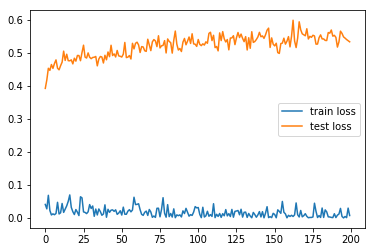

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()

training_process = False

if not training_process:
  # Re-load trained model
  my_classifier.load_state_dict(ckpt['my_classifier'])
  optimizer.load_state_dict(ckpt['optimizer'])

  # Testing
  n = 0.
  test_loss = 0.
  test_acc = 0.
  my_classifier.eval()
  for test_inputs, test_labels in test_dataloader:
    test_inputs = test_inputs.to(device)
    test_labels = test_labels.to(device)

    logits = my_classifier(test_inputs)
    test_loss += F.cross_entropy(logits, test_labels, reduction='sum').item()
    test_acc += (logits.argmax(dim=1) == test_labels).float().sum().item()
    n += test_inputs.size(0)

  test_loss /= n
  test_acc /= n
  print('Test_loss : {:.4f}, Test accuracy : {:.4f}'.format(test_loss, test_acc))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label : car
prediction : car


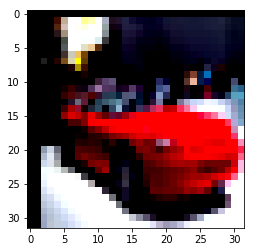

In [13]:
import random

import matplotlib.pyplot as plt
import numpy as np

my_classifier.eval()

num_test_samples = len(test_dataset)
random_idx = random.randint(0, num_test_samples)

test_input, test_label = test_dataset.__getitem__(random_idx)
test_prediction = F.softmax(my_classifier(test_input.unsqueeze(0).to(device)), dim=1).argmax().item()
print('label : %s' % classes[test_label])
print('prediction : %s' % classes[test_prediction])

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# show images
imshow(torchvision.utils.make_grid(test_input))

# <font color="blue"> Discussion and Analysis </font>

<font color="blue"> Fill here with your discussion </font>